<a href="https://colab.research.google.com/github/dlfelps/ml_portfolio/blob/main/generative_ai_cub.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook demonstrates how to generate synthetic data using diffusion models.

It has a companion [blog post](https://dlfelps.github.io/2024/08/01/generative.html).

It is part of Daniel Felps' [ML portfolio](https://github.com/dlfelps/ml_portfolio/tree/main)

# Introduction

The central idea of generative modelling is to train a model that is capable of producing samples from the same distribution as the training data distribution. There are five primary approaches to generative modeling:

*   Generative Adversarial Networks
*   Energy-based models
*   Variational Autoencoders
*   Autoregressive models
*   Normalizing flows

A good comparison of the strengths and weaknesses of each approach is presented in [Table 1 of *Deep Generative Modelling*](https://arxiv.org/abs/2103.04922). The focus of this post is on diffusion models, which are a type of energy-based model that produce high quality images.


<p align="center">
    <img src="https://developer-blogs.nvidia.com/wp-content/uploads/2022/04/GANs_Diffusion_Autoencoders.png" width="400"/>
    <br>
    <em> Figure from NVIDIA (https://developer.nvidia.com/blog/improving-diffusion-models-as-an-alternative-to-gans-part-1/). </em>
<p>

# Setup Environment

In [1]:
%%capture
!pip install diffusers["torch"] transformers

In [ ]:
%%capture
!git clone https://github.com/dlfelps/generative_bird.git

In [3]:
# GPU runtime recommended
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# Unconditional image generation (Denoising Diffusion Probabilistic Models)

Denoising Diffusion Probabilistic Models (DDPM) are neural networks that are trained to predict slightly less noisy images from a noisy input. At inference, they can be used to iteratively transform random noise to generate an image:

<p align="center">
    <img src="https://developer-blogs.nvidia.com/wp-content/uploads/2022/04/Fixed_Forward_Diffusion_Process.png" width="800"/>
    <br>
    <em> Figure from NVIDIA (https://developer.nvidia.com/blog/improving-diffusion-models-as-an-alternative-to-gans-part-1/). </em>
<p>



I trained a DDPM on the CUB-2011 dataset. DDPMs require serious GPU to train. I had to downsample the dataset to 64x64 to get it to train on a single GPU. You can try out the pretrained model below:

In [4]:
from diffusers import DiffusionPipeline

pipeline = DiffusionPipeline.from_pretrained("dlfelps/ddpm-cub2011-64")
pipeline = pipeline.to(device)

Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

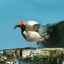

In [ ]:
low_res_img = pipeline().images[0] #takes about 20 minutes on CPU (GPU recommended)
low_res_img.save('low_res_img.png')
low_res_img

# Generating higher resolution images - upscaling

There

In [ ]:
from diffusers import StableDiffusionUpscalePipeline

model_index.json:   0%|          | 0.00/485 [00:00<?, ?B/s]

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/825 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/634 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/348 [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/982 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

low_res_scheduler/scheduler_config.json:   0%|          | 0.00/300 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.36G [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/587 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/1.89G [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/221M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

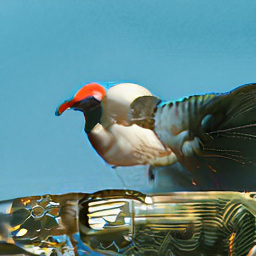

In [ ]:
pipeline = StableDiffusionUpscalePipeline.from_pretrained("stabilityai/stable-diffusion-x4-upscaler")
pipeline = pipeline.to(device)

upscaled_image = pipeline(prompt='bird', image=low_res_img).images[0]
upscaled_image.save('upscaled_image.png')
upscaled_image

The output image is 256x256 (upscaled from 64x64). Your mileage may vary, but it should look similar to the low_res_img that was sampled from the DDPM above. In my experiments with the upscaler, the details of the picture didn't agree with a bird or a bird's natural environment. That is partially due to the DDPM and partially due to the fact that the upscaler is trained on a subset (10M images) of [LAION-5B](https://laion.ai/blog/laion-5b/).

Upscaling tends to be more useful for images that are already high quality - making them even higher quality.


# Generating higher resolution images - latent model

Upscaling wasn't the answer to generating high-resolution synthetic images. The next technique was introduced in [*High-Resolution Image Synthesis with Latent Diffusion Models*](https://arxiv.org/abs/2112.10752). As the title suggests, we are going to adapt a DDPM to use a latent space instead of pixel space.

Following the paper, I used a pretrained variational autoencoder to compress high-resolution images (512x512x3) into a smaller latent space (64x64x4). This size permits me to train a DDPM on a single GPU.

Generating samples with this model

In [ ]:
from generative_bird.pipeline_lddpm import LDDPMPipeline
from diffusers import UNet2DModel, DDPMScheduler


unet = UNet2DModel.from_pretrained("dlfelps/unet-cub2011-latent-64")
pipeline = LDDPMPipeline(unet=unet, scheduler=DDPMScheduler())
pipeline = pipeline.to(device)

config.json:   0%|          | 0.00/1.07k [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/444M [00:00<?, ?B/s]

In [ ]:
from diffusers.image_processor import VaeImageProcessor
from diffusers import AutoencoderKL

def return_decoder_closure(vae):
  image_processor = VaeImageProcessor(vae_scale_factor=8, do_resize=False, do_normalize=True)
  def decoder(z):
    with torch.no_grad():
      z = z.to(device)
      z = torch.divide(z, torch.tensor(0.18215))
      image = vae.decode(z).sample.detach().cpu()

    image = image_processor.postprocess(image)

    return image
  return decoder

vae = AutoencoderKL.from_pretrained("runwayml/stable-diffusion-v1-5", subfolder='vae')
vae = vae.to(device)
decoder = return_decoder_closure(vae)

  0%|          | 0/1000 [00:00<?, ?it/s]

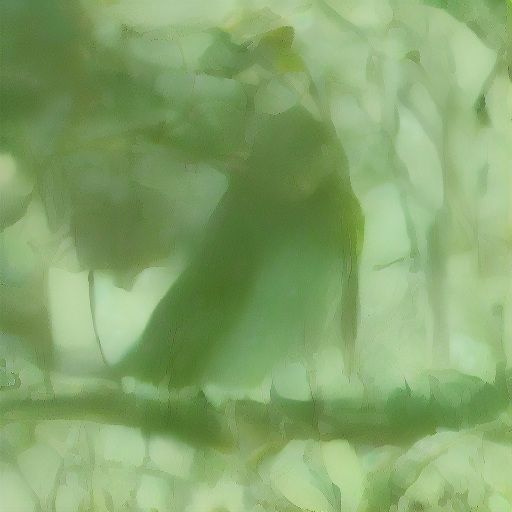

In [ ]:

latent_img = pipeline().images[0] #takes about 20 minutes on CPU (GPU recommended)
decoded_latent_img = decoder(latent_img.unsqueeze(0))[0]
decoded_latent_img.save('decoded_latent_img.png')
decoded_latent_img

Although the model outputs images that are 512x512, I admit that they don't look very bird-like. The approach is sound in general, but it needed to train for longer than my Colab budget allowed. As a comparison, in [*High-Resolution Image Synthesis with Latent Diffusion Models*](https://arxiv.org/abs/2112.10752), they trained a latent model on [FFHQ](https://github.com/NVlabs/ffhq-dataset) for 283 hours on an A100. This would cost an equivalent of $370 in Colab compute units so forgive me for stopping early! You get the picture ;)

# Conditional image generation (Stable Diffusion)

The previous models provided no way to control their outputs (i.e. they were unconditional models). Another advancement described in [*High-Resolution Image Synthesis with Latent Diffusion Models*](https://arxiv.org/abs/2112.10752) was the ability to provide additional information to the image synthesis process as a way to condition the generation process. The most common form of conditioning is via a text prompt.

<p align="center">
    <img src="https://raw.githubusercontent.com/patrickvonplaten/scientific_images/master/stable_diffusion.png" width="400"/>
    <br>
    <em> Figure from HUGGINGFACE (https://huggingface.co/blog/stable_diffusion). </em>
<p>

**BEFORE CONTINUING PLEASE READ AND AGREE TO STABLE DIFFUSION [LICENSE AND TERMS](https://huggingface.co/runwayml/stable-diffusion-v1-5)**

In [ ]:
from diffusers import DiffusionPipeline

pipeline = DiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5")
pipeline = pipeline.to(device)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

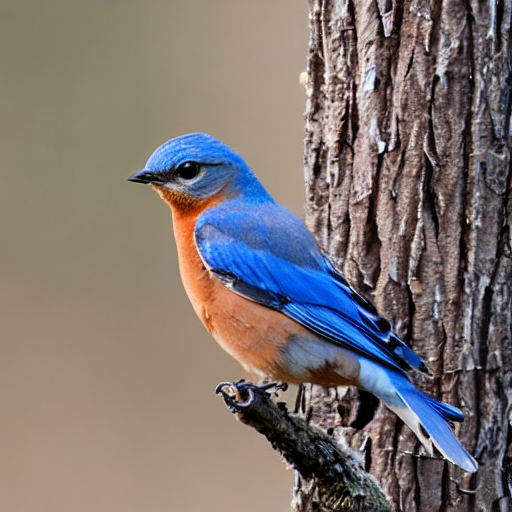

In [ ]:

conditioned_image = pipeline("an eastern bluebird sitting on a branch").images[0]
conditioned_image.save('conditioned_image.png')
conditioned_image

SUCCESS!